## Econometric estimation of an IRL-based market portfolio model. Part II: QED

Welcome to your final course project on Advanced Topic RL in Finance. In this project you will: 

- Explore and estimate an IRL-based model of market returns (the "QED" model) that is obtained by a generalization of   a model that you analyzed in the previous course
- Respectively, you are expected to re-utilize parts of your previous code from the course project from Course 3: RL (but you can also start from scratch - the template provided here is nearly identical to the one offered to you in course 3)
- Investige the role of non-linearities in price dynamics
- Investigate the role and impact of choices of different signals on model estimation and trading strategies
 

**Instructions for project structure and grading principles :**

- This is a project that will be graded based on a peer-to-peer review. The project consists of four parts. The maximum score for each part is 10, so that maximum score you can give your peers (and they can give you) is 40. The parts are as follows (more detailed instructions are in specific cells below):

- **Part 1**: Estimate the model using the DJI portfolio of 30 stocks, first without signals, and then using simple signals such as simple moving averages constructed below (Max 10 point).

- **Part 2**: Explore the implications of calibrated model parameters for default probabilities of stocks in your portfolio. Present your conclusions and observations. (Max 10 point).

- **Part 3**: Experiment with other signals and investigate the impact on model calibration obtained with alternative signals. Present your conclusions and observations. (Max 10 points).

- **Part 4** : Show me something else. This part is optional. Come up with your own idea of an interesting analysis.
For example, you can repeat your analysis for the S&P portfolio.
Or maybe you can build a strategy using an optimal market-implied policy estimated from this model, and compare it with PCA and absorption ratio strategies that we built in Course 2. Or anything else.  (Max 10 points).

**Instructions for formatting your notebook and packages use can use **

- Use one or more cells of the notebook for each section of the project. Each section is marked by a header cell below. Insert your cells between them without changing the sequence. 

- Think of an optimal presentation of your results and conclusions. Think of how hard or easy it will be for your fellow students to follow your logic and presentation. When you are grading others, you can add or subtract point for the quality of presentation.

- You will be using Python 3 in this project. Using TensorFlow is encouraged but is not strictly necessary, you can use optimization algorithms available in scipy or scikit-learn packages. If you use any non-standard packages, you should state all neccessary additional imports (or instructions how to install any additional modules you use in a top cell of your notebook. If you create a new portfolio for parts 3 and 4 in the project, make your code for creating your dataset replicable as well, so that your grader can reproduce your code locally on his/her machine.   

- Try to write a clean code that can be followed by your peer reviewer. When you are the reviewer, you can add or subtract point for the quality of code. 


**After completing this project you will:**
- Get experience with building and estimation of your second IRL based model of market dynamics.
- Develop intuition and understanding about the role of non-linearities in dynamics model. 
- Develop intuition on whether the same model could be calibrated to both equity and credit data.
- Be able to implement trading strategies based on this method.

Let's get started!

## The "Quantum Equlibrium-Disequlibrium" (QED) IRL-based model of stock returns

In Week 3 lectures of our course we presented the "QED" model
$$
d X_t = \kappa X_t  \left( \frac{\theta}{\kappa} - X_t - \frac{g}{\kappa} X_t^2 \right) dt +  X_t \left( {\bf w} {\bf z}_t \, dt + \sigma d W_t \right)
$$

In this project, you will explore calibration of this model to market data.
As in the course project for course 3 you analyzed the same model in the limit $ g = 0 $, you would be able to re-utilize parts of your previous code in this project).


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

import matplotlib.pyplot as plt
from datetime import datetime

In [2]:
# read the data to a Dataframe
df_cap = pd.read_csv('dja_cap.csv')

In [3]:
# add dates
dates = pd.bdate_range(start='2010-01-04', end=None, periods=df_cap.shape[0], freq='B')
df_cap['date'] = dates

df_cap.set_index('date',inplace=True)
df_cap.head()


,AAPL,AXP,BA,CAT,CSCO,CVX,DIS,DWDP,GE,GS,...,NKE,PFE,PG,TRV,UNH,UTX,V,VZ,WMT,XOM
date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.937540e+11,4.866080e+10,4.082033e+10,3.646072e+10,1.420310e+11,1.586160e+11,6.168697e+10,3.337392e+10,1.645040e+11,8.897731e+10,...,25598248500,1.527560e+11,1.785760e+11,27214839130,3.663840e+10,6.715592e+10,4.133704e+10,9.453677e+10,2.066260e+11,3.272110e+11
2010-01-05,1.940890e+11,4.855377e+10,4.215727e+10,3.689663e+10,1.413990e+11,1.597390e+11,6.153308e+10,3.486077e+10,1.653560e+11,9.055040e+10,...,25700093100,1.505780e+11,1.786350e+11,26570118990,3.658030e+10,6.615275e+10,4.086336e+10,9.470720e+10,2.045680e+11,3.284880e+11
2010-01-06,1.910010e+11,4.933862e+10,4.343609e+10,3.700873e+10,1.404780e+11,1.597590e+11,6.120609e+10,3.547838e+10,1.645040e+11,8.958393e+10,...,25543409100,1.500930e+11,1.777880e+11,26193121620,3.694052e+10,6.580586e+10,4.031464e+10,9.067348e+10,2.041110e+11,3.313270e+11
2010-01-07,1.906480e+11,4.992131e+10,4.519446e+10,3.715818e+10,1.411110e+11,1.591570e+11,6.122532e+10,3.550126e+10,1.730220e+11,9.133695e+10,...,26172872700,1.495290e+11,1.768230e+11,26570118990,3.835818e+10,6.608712e+10,4.068983e+10,9.013376e+10,2.042250e+11,3.302860e+11
2010-01-08,1.919160e+11,4.988564e+10,4.475850e+10,3.757541e+10,1.418590e+11,1.594380e+11,6.132150e+10,3.562706e+10,1.767480e+11,8.960963e+10,...,26121202640,1.507390e+11,1.765900e+11,26531872880,3.799796e+10,6.621838e+10,4.080239e+10,9.019057e+10,2.031960e+11,3.289620e+11


## Let us build some signals 

Here we provide a "warm start" by computing two simple moving average signals that you can use as benchmark in your analysis.

### Generate moving averages

In [4]:
# Calculating the short-window (10 days) simple moving average

window_1 = 10

short_rolling = df_cap.rolling(window=window_1).mean()
# short_rolling.head(20)

In [5]:
# Calculating the long-window (30 days) simple moving average

window_2 = 30
long_rolling = df_cap.rolling(window=window_2).mean()
# long_rolling.tail()

### Plot three years of AAPL stock:

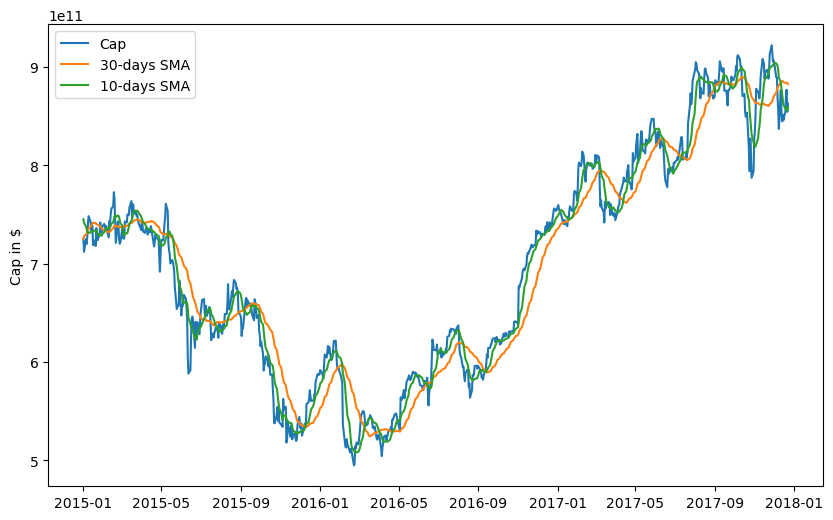

In [6]:
ticker = 'AAPL'
start_date = '2015-01-01'
end_date = '2017-12-31'

fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)

ax.plot(df_cap.loc[start_date:end_date, :].index, df_cap.loc[start_date:end_date, 'AAPL'], label='Cap')
ax.plot(long_rolling.loc[start_date:end_date, :].index, long_rolling.loc[start_date:end_date, 'AAPL'], 
          label = '%d-days SMA' % window_2)
ax.plot(short_rolling.loc[start_date:end_date, :].index, short_rolling.loc[start_date:end_date, 'AAPL'], 
         label = '%d-days SMA' % window_1)

ax.legend(loc='best')
ax.set_ylabel('Cap in $')

plt.show()

## Part 1: Model calibration with or without moving average signals (Max 10 points)

To calibrate the model, it is convenient to use the log-prices instead of prices. Diffusion in the log-space 
$ y = \log x $ is given by the following Langevin equation:

$$
d y_t = - \frac{ \partial V(y)}{\partial y} dt + \sigma dW_t , \; \; \;  V(y)  \equiv - \left( \theta - \frac{\sigma^2}{2} + {\bf w} {\bf z}_t \right) y  + \kappa e^y + \frac{1}{2} g e^{2y}
$$

where $ W_t $ is a standard Brownian motion.
In terms of variables $ y = \log x $, the negative log-likelihood of data is therefore

$$
LL_M (\Theta) = - \log \prod_{t=0}^{T-1} 
\frac{1}{ \sqrt{ 2 \pi  \sigma^2}  } 
\exp \left\{  - \frac{1}{2 \sigma^2} \left(   \frac{ y_{t+ \Delta t} -   y_{t}}{ \Delta t} +  \frac{ \partial V(y)}{\partial y}   
\right)^2
\right\} , 
$$ 

where $ {\bf y}_t  = \log x_t $  now stands for observed values of log-cap. Note that because the model is Markov, the product over $ t = 0, \ldots, T-1 $ does not 
necessarily mean a product of transitions along the same trajectory. The negative log-likelihood should be minimized to estimate parameters $ 
\theta $, $ \sigma $, $ \kappa $, $ g $ and  $ {\bf w} $. You can try to estimate the model first without signals, then with signals.


In [7]:
# ---CELL 7: Data Prep ---

#Auditability (grounding toggle)
np.random.seed(42)
tf.random.set_seed(42)

# Global Scaling
#avg_market_cap = df_cap.sum(axis=1).mean()
avg_market_cap = df_cap.values.mean()
df_cap_avg = df_cap / avg_market_cap

# Re-basing SMAs (Setting each starting signal to 1.0)
short_avg = short_rolling / avg_market_cap
long_avg = long_rolling / avg_market_cap

short_rebased = short_avg / short_avg.apply(lambda x: x.loc[x.first_valid_index()])
long_rebased = long_avg / long_avg.apply(lambda x: x.loc[x.first_valid_index()])

# Signals as Arithmetic Returns
signal_1 = short_rebased.pct_change(periods=1)
signal_2 = long_rebased.pct_change(periods=1)

# Alignment
mkt_cap_subset = df_cap_avg[:-1]
common_idx = signal_1.dropna().index.intersection(signal_2.dropna().index).intersection(mkt_cap_subset.index)

x_data = mkt_cap_subset.loc[common_idx]
z1_data = signal_1.loc[common_idx]
z2_data = signal_2.loc[common_idx]

# Tensors
x_t = tf.constant(x_data.values, dtype=tf.float32)
z1_t = tf.constant(z1_data.values, dtype=tf.float32)
z2_t = tf.constant(z2_data.values, dtype=tf.float32)

num_steps, num_stocks = x_t.shape
print(f"Data Prepared. Steps: {num_steps}, Stocks: {num_stocks}")
#print(df_cap_avg.head())

Data Prepared. Steps: 2049, Stocks: 30


In [8]:
# --- CELL 8: QED Model w/out Signals ---

# Variable Initializations
kappa = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.1), name="kappa")
sigma = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.1), name="sigma")
theta = tf.Variable(tf.random.uniform([num_stocks], minval=-0.01, maxval=0.01), name="theta")
g = tf.Variable(tf.random.uniform([num_stocks], minval=0.0, maxval=0.00001), name="g")

def get_loss_no_signals():
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    dy = log_x_next - log_x

    # Derivative dV/dy = -(theta - sigma²/2 + w·z) + kappa*exp(y) + g*exp(2y)
    # exp_dy = (theta - 0.5 * tf.square(sigma)) + kappa * tf.exp(log_x) + g * tf.exp(2.0 * log_x)
    exp_dy = (theta - 0.5 * tf.square(sigma)) - kappa * tf.exp(log_x) - g * tf.exp(2.0 * log_x)

    # Residual
    v_res = (dy - exp_dy)[:-1, :]
    
    # 5. Gaussian Negative Log Likelihood
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma)))

    # log_det = T_eff * tf.reduce_sum(tf.math.log(2.0 * np.pi * tf.square(sigma)))

    NLL = 0.5 * (sq_dist + log_det)

    return NLL

In [9]:
# --- CELL 9: Optimization (no signals)---
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
variables = [kappa, sigma, theta ,g]

print("Calibrating Model...")
for i in range(2001):
    with tf.GradientTape() as tape:
        loss_val_0 = get_loss_no_signals()
    
    # Gradients
    grads = tape.gradient(loss_val_0, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Stability constraints
    kappa.assign(tf.clip_by_value(kappa, -1.0, 1.0))
    sigma.assign(tf.maximum(0.00001, sigma))
    theta.assign(tf.clip_by_value(theta, -0.5, 0.5))
    g.assign(tf.clip_by_value(g, -0.1, 0.1))
    
    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val_0.numpy():.4f}")

print("Done")

loss_no_signals = loss_val_0.numpy()
kappa_init = kappa.numpy().copy()
sigma_init = sigma.numpy().copy()
g_init = g.numpy().copy()
theta_init = theta.numpy().copy()

Calibrating Model...
Iteration    0 | Loss: -107288.8281
Iteration  500 | Loss: -224588.1562
Iteration 1000 | Loss: -233435.8281
Iteration 1500 | Loss: -234496.6250
Iteration 2000 | Loss: -234585.1719
Done


In [10]:
# --- CELL 10: Results (No Signals) ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

results = {
    'Ticker': x_data.columns,
    'Theta': theta.numpy(),
    'Kappa': kappa.numpy(),
    'Sigma': sigma.numpy(),
    'g': g.numpy()
}

df_results = pd.DataFrame(results)

print("-Part 1: Baseline Calibration Results (No Signals)-")
display(df_results)  # Use display() instead

significant_g = df_results[df_results['g'].abs() > 1e-3].shape[0]
print(f"\nStocks with detectable non-linear dynamics: {significant_g} / {num_stocks}")


-Part 1: Baseline Calibration Results (No Signals)-


,Ticker,Theta,Kappa,Sigma,g
0,AAPL,0.043766,0.026298,0.016568,-0.003647
1,AXP,0.008409,0.029685,0.014705,-0.024855
2,BA,0.001079,0.001320,0.014947,-0.001292
3,CAT,0.007476,0.028870,0.016662,-0.025440
4,CSCO,0.006427,0.012902,0.016084,-0.006315
5,CVX,0.029737,0.043475,0.013405,-0.015693
6,DIS,0.012019,0.031100,0.013588,-0.018807
7,DWDP,0.009723,0.038106,0.023347,-0.029336
8,GE,0.007782,0.011397,0.014048,-0.003983
9,GS,0.005298,0.014354,0.016819,-0.007158



Stocks with detectable non-linear dynamics: 27 / 30


In [11]:
# --- CELL 11: QED Model with Signals ---

# Reinitialize Variables
kappa = tf.Variable(kappa_init, name="kappa")  # Initialize from Part 1
sigma = tf.Variable(sigma_init, name="sigma")
theta = tf.Variable(theta_init, name="theta")
g = tf.Variable(g_init, name="g")

# Weight Logits:
w_logits = tf.Variable(tf.random.normal([num_stocks, 2], mean=0.0, stddev=0.1), name="w_logits")

def get_loss():
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    dy = log_x_next - log_x #VAM as drift term
    
    # Signals
    z1_log = tf.math.log(1.0 + z1_t)
    z2_log = tf.math.log(1.0 + z2_t)

    W1 = w_logits[:, 0] 
    W2 = w_logits[:, 1]
    wtd_rets = W1 * z1_log + W2 * z2_log
    
    # Expected Return
    exp_dy = (theta - 0.5 * tf.square(sigma) + wtd_rets) - kappa * tf.exp(log_x) - g * tf.exp(2.0 * log_x)

    # Residual
    v_res = (dy - exp_dy)[:-1, :]
    
    # Gaussian Negative Log Likelihood
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma)))
    
    NLL = 0.5 * (sq_dist + log_det)
    
    return NLL

In [12]:
# --- CELL 12: Optimization ---
optimizer = tf.optimizers.Adam(learning_rate=0.0001)
variables = [theta, kappa, sigma, g, w_logits]

print("Calibrating 2-Signal Model...")
for i in range(3001):
    with tf.GradientTape() as tape:
        loss_val_1 = get_loss()
    
    # Gradients
    grads = tape.gradient(loss_val_1, variables)
    optimizer.apply_gradients(zip(grads, variables))
    
    # Stability constraints
    kappa.assign(tf.clip_by_value(kappa, -1.0, 1.0))
    sigma.assign(tf.maximum(0.00001, sigma))
    theta.assign(tf.clip_by_value(theta, -0.5, 0.5))
    g.assign(tf.clip_by_value(g, -0.1, 0.1))
    
    if i % 750 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val_1.numpy():.4f}")

print("Done")

# --- Signal Contribution Analysis ---
W1, W2 = w_logits[:, 0], w_logits[:, 1]

z1_log = tf.math.log(1.0 + z1_t)
z2_log = tf.math.log(1.0 + z2_t)

ma10_cont = W1 * z1_log
ma30_cont = W2 * z2_log

print(f"\nSignal Contribution Analysis (2-Signal):")
print(f"MA10 contribution std: {tf.math.reduce_std(ma10_cont).numpy():.6f}")
print(f"MA30 contribution std: {tf.math.reduce_std(ma30_cont).numpy():.6f}")

loss_with_signals = loss_val_1.numpy()

Calibrating 2-Signal Model...
Iteration    0 | Loss: -234549.9062
Iteration  750 | Loss: -234776.1094
Iteration 1500 | Loss: -234813.8750
Iteration 2250 | Loss: -234830.2500
Iteration 3000 | Loss: -234836.9062
Done

Signal Contribution Analysis (2-Signal):
MA10 contribution std: 0.000458
MA30 contribution std: 0.000293


In [13]:
# --- CELL 13: Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Weights
final_weights = w_logits.numpy()
W1_final = final_weights[:, 0]
W2_final = final_weights[:, 1]

results = {
    'Ticker': df_cap.columns,
    'Theta': theta.numpy(),
    'Kappa': kappa.numpy(),
    'Sigma': sigma.numpy(),
    'g': g.numpy(),
    'W1 (MA10)': W1_final,
    'W2 (MA30)': W2_final
}
df_results = pd.DataFrame(results)

print("----------------- Part 1: Final Calibration of MLE Results -----------------")
display(df_results)

# Check for g values significantly different from zero
significant_g = df_results[df_results['g'].abs() > 1e-3].shape[0]
print(f"\nStocks with detectable non-linear dynamics: {significant_g} / {num_stocks}")

----------------- Part 1: Final Calibration of MLE Results -----------------


,Ticker,Theta,Kappa,Sigma,g,W1 (MA10),W2 (MA30)
0,AAPL,0.004902,0.001813,0.015774,-0.000191,-0.070036,0.063889
1,AXP,0.010692,0.040443,0.014692,-0.037269,-0.101256,-0.088149
2,BA,0.000746,0.000162,0.014924,-0.000153,-0.148031,0.265192
3,CAT,0.009151,0.037947,0.016659,-0.036924,-0.027180,0.096979
4,CSCO,0.005677,0.011702,0.016074,-0.006039,-0.026112,-0.128729
5,CVX,0.011060,0.012633,0.013392,-0.003210,-0.064358,-0.012200
6,DIS,-0.001597,-0.009071,0.013510,0.007254,-0.178432,0.163752
7,DWDP,-0.000753,-0.008489,0.023266,0.007393,-0.087250,0.042024
8,GE,-0.012268,-0.018999,0.014019,0.007098,-0.093035,0.127096
9,GS,0.004340,0.008590,0.016809,0.000599,-0.056293,0.186445



Stocks with detectable non-linear dynamics: 24 / 30


In [14]:
# --- CELL 14: Comparison Summary ---

# Create no-signals results DataFrame from saved initial values
df_results_no_sig = pd.DataFrame({
    'Ticker': x_data.columns,
    'Theta': theta_init,
    'Kappa': kappa_init,
    'Sigma': sigma_init,
    'g': g_init
})

# Count significant g values
significant_g_no_sig = (df_results_no_sig['g'].abs() > 1e-3).sum()
significant_g_with_sig = (df_results['g'].abs() > 1e-3).sum()

# Create comparison table
comparison = pd.DataFrame({
    'Metric ': [
        'Mean Kappa ',
        'Mean Sigma ', 
        'Mean g ',
        'Mean Theta ',
        'Mean MA10 (W1) ',
        'Mean MA30 (W2) ',
        'Final NLL ',
        'Significant g Stocks '
    ],
    'No Signals': [
        f"{df_results_no_sig['Kappa'].abs().mean():.6f}",
        f"{df_results_no_sig['Sigma'].mean():.6f}",
        f"{df_results_no_sig['g'].abs().mean():.6f}",
        f"{df_results_no_sig['Theta'].abs().mean():.6f}",
        'N/A',
        'N/A',
        f"{loss_no_signals:.2f}",
        f"{significant_g_no_sig}"
    ],
    'W/Signals': [
        f"{df_results['Kappa'].abs().mean():.6f}",
        f"{df_results['Sigma'].mean():.6f}",
        f"{df_results['g'].abs().mean():.6f}",
        f"{df_results['Theta'].abs().mean():.6f}",
        f"{df_results['W1 (MA10)'].mean():.6f}",
        f"{df_results['W2 (MA30)'].mean():.6f}",
        f"{loss_with_signals:.2f}",
        f"{significant_g_with_sig}"
    ]
})


print("---- COMPARISON: With & W/out Signals -----")
print(comparison.to_string(index=False))


---- COMPARISON: With & W/out Signals -----
              Metric  No Signals  W/Signals
          Mean Kappa    0.023961   0.011658
          Mean Sigma    0.013607   0.013548
              Mean g    0.014130   0.007656
          Mean Theta    0.013068   0.005099
      Mean MA10 (W1)         N/A  -0.094562
      Mean MA30 (W2)         N/A  -0.029966
           Final NLL  -234585.17 -234836.91
Significant g Stocks          27         24


## Part 2: Analysis of default rates  (Max 10 point)

For a particle in a potential $ V(y) $ with a metastable minimum $ y = a $ and a barrier with a peak located at $ y = b $, the famous Kramers' escape formula gives the following expression for the escape rate $ r $ (see e.g. the book by van Kampen):

$$ 
r = \frac{\sqrt{ V''(a) \left| V''(b) \right| }}{2 \pi} \exp \left[ - \frac{2}{\sigma^2} (V(b) - V(a) ) \right]
$$

Here $ V''(a) $ and $ V''(b) $ stand for the second derivatives of the potential $ V(y) $ at the minimum and the maximum, respectively. This formula applies as long as the barrier height $ \Delta E \equiv  (V(b) - V(a) \gg \frac{\sigma^2}{2} $. 

Apply the Kramers formula to the QED potential and parameters that you found in your calibration. What range of values of $ r $ do you obtain? Do these values make sense to you? Can you think how you could use the Kramers relation as a way to regularize your MLE calibration?


In [15]:
# --- CELL 15: Final Calibration ---

# Extract parameters from the calibrated tensors
t_final = theta.numpy()
k_final = kappa.numpy()
s_final = sigma.numpy()
g_final = g.numpy()

y_min_list = []
y_bar_list = []
r_list = []
barrier_pass_list = []

for i in range(num_stocks):
    t, k, s, g_val = t_final[i], k_final[i], s_final[i], g_final[i]
    alpha = t - 0.5 * s**2
    
    # Critical Points: V'(y) = 0 => g*u^2 + k*u - alpha = 0 (u = exp(y))
    u_roots = np.roots([g_val, k, -alpha])
    u_real = u_roots[np.isreal(u_roots)].real
    u_pos = sorted(u_real[u_real > 0])
    
    y_min_val, y_bar_val, r_val, pass_test = np.nan, np.nan, np.nan, False
    
    if len(u_pos) == 2:
        u_1, u_2 = u_pos[0], u_pos[1]
        
        # Second Derivatives: V''(y) = k*u + 2*g*u^2
        v_pp_1 = k * u_1 + 2 * g_val * u_1**2
        v_pp_2 = k * u_2 + 2 * g_val * u_2**2
        
        # One minimum (V'' > 0), one maximum (V'' < 0)
        if (v_pp_1 * v_pp_2) < 0:
            u_min = u_1 if v_pp_1 > 0 else u_2
            u_max = u_2 if v_pp_1 > 0 else u_1
            
            y_min_val = np.log(u_min)
            y_bar_val = np.log(u_max)
            
            # Potential Difference (y-space)
            V = lambda y_val: -alpha * y_val + k * np.exp(y_val) + 0.5 * g_val * np.exp(2 * y_val)
            delta_V = V(y_bar_val) - V(y_min_val)

            # Kramers Rate Formula
            if delta_V > 0:
                curv_min = k * u_min + 2 * g_val * u_min**2
                curv_max = k * u_max + 2 * g_val * u_max**2
                prefactor = np.sqrt(curv_min * abs(curv_max)) / (2 * np.pi)
                r_val = prefactor * np.exp(-delta_V / (s**2))
                pass_test = delta_V > 3 * (s**2) / 2

    y_min_list.append(y_min_val)
    y_bar_list.append(y_bar_val)
    r_list.append(r_val)
    barrier_pass_list.append(pass_test)



In [16]:
# --- CELL 16: Kramer's r Results ---
#  Create result DataFrame
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

df_results = pd.DataFrame({
    'Ticker': x_data.columns,
    'Theta': t_final,
    'Kappa': k_final,
    'Sigma': s_final,
    'g': g_final,
    'Escape_r': r_list,
    'Bar Pass': barrier_pass_list,
    'y_min': y_min_list,
    'y_max': y_bar_list
})

significant_g = df_results[df_results['g'].abs() > 1e-3].shape[0]

print("--------------------- Part 2: Final Calibration & Kramer's r Results ---------------------")
display(df_results)
print(f"\nStocks with detectable non-linear dynamics: {significant_g} / {num_stocks}")


--------------------- Part 2: Final Calibration & Kramer's r Results ---------------------


,Ticker,Theta,Kappa,Sigma,g,Escape_r,Bar Pass,y_min,y_max
0,AAPL,0.004902,0.001813,0.015774,-0.000191,NaN,False,NaN,NaN
1,AXP,0.010692,0.040443,0.014692,-0.037269,4.097761e-04,False,-0.819594,-0.439203
2,BA,0.000746,0.000162,0.014924,-0.000153,NaN,False,NaN,NaN
3,CAT,0.009151,0.037947,0.016659,-0.036924,3.049996e-04,False,-0.987482,-0.422864
4,CSCO,0.005677,0.011702,0.016074,-0.006039,2.384760e-04,False,-0.189970,0.105194
5,CVX,0.011060,0.012633,0.013392,-0.003210,2.818584e-05,True,0.257350,0.971625
6,DIS,-0.001597,-0.009071,0.013510,0.007254,1.263055e-06,True,0.022694,-1.480343
7,DWDP,-0.000753,-0.008489,0.023266,0.007393,1.769145e-05,True,0.011265,-1.988284
8,GE,-0.012268,-0.018999,0.014019,0.007098,4.459663e-04,False,0.444247,0.110862
9,GS,0.004340,0.008590,0.016809,0.000599,NaN,False,NaN,NaN



Stocks with detectable non-linear dynamics: 24 / 30


In [17]:
# --- CELL 17: Interpretation and Analysis ---

valid_rates = df_results[df_results['Escape_r'].notna()]
passed_barrier = df_results[df_results['Bar Pass'] == True]

print(f"\nStocks with valid barrier structure: {len(valid_rates)} / {num_stocks}")
print(f"Stocks passing barrier significance test (ΔV > 3σ²/2): {len(passed_barrier)} / {num_stocks}")

if len(valid_rates) > 0:
    print(f"\nEscape Rate Statistics:")
    print(f"  Mean:   {valid_rates['Escape_r'].mean():.6e} per day")
    print(f"  Median: {valid_rates['Escape_r'].median():.6e} per day")
    print(f"  Min:    {valid_rates['Escape_r'].min():.6e} per day")
    print(f"  Max:    {valid_rates['Escape_r'].max():.6e} per day")
    
    # Convert to annual default probability: P(default) = 1 - exp(-r * 252)
    annual_default = 1 - np.exp(-valid_rates['Escape_r'] * 252)
    
    print(f"\nImplied Annual Default Probabilities:")
    print(f"  Mean:   {annual_default.mean():.2%}")
    print(f"  Median: {annual_default.median():.2%}")
    print(f"  Range:  [{annual_default.min():.2%}, {annual_default.max():.2%}]")


Stocks with valid barrier structure: 22 / 30
Stocks passing barrier significance test (ΔV > 3σ²/2): 13 / 30

Escape Rate Statistics:
  Mean:   1.346765e-04 per day
  Median: 3.102540e-05 per day
  Min:    2.413437e-32 per day
  Max:    5.548793e-04 per day

Implied Annual Default Probabilities:
  Mean:   3.25%
  Median: 0.78%
  Range:  [0.00%, 13.05%]


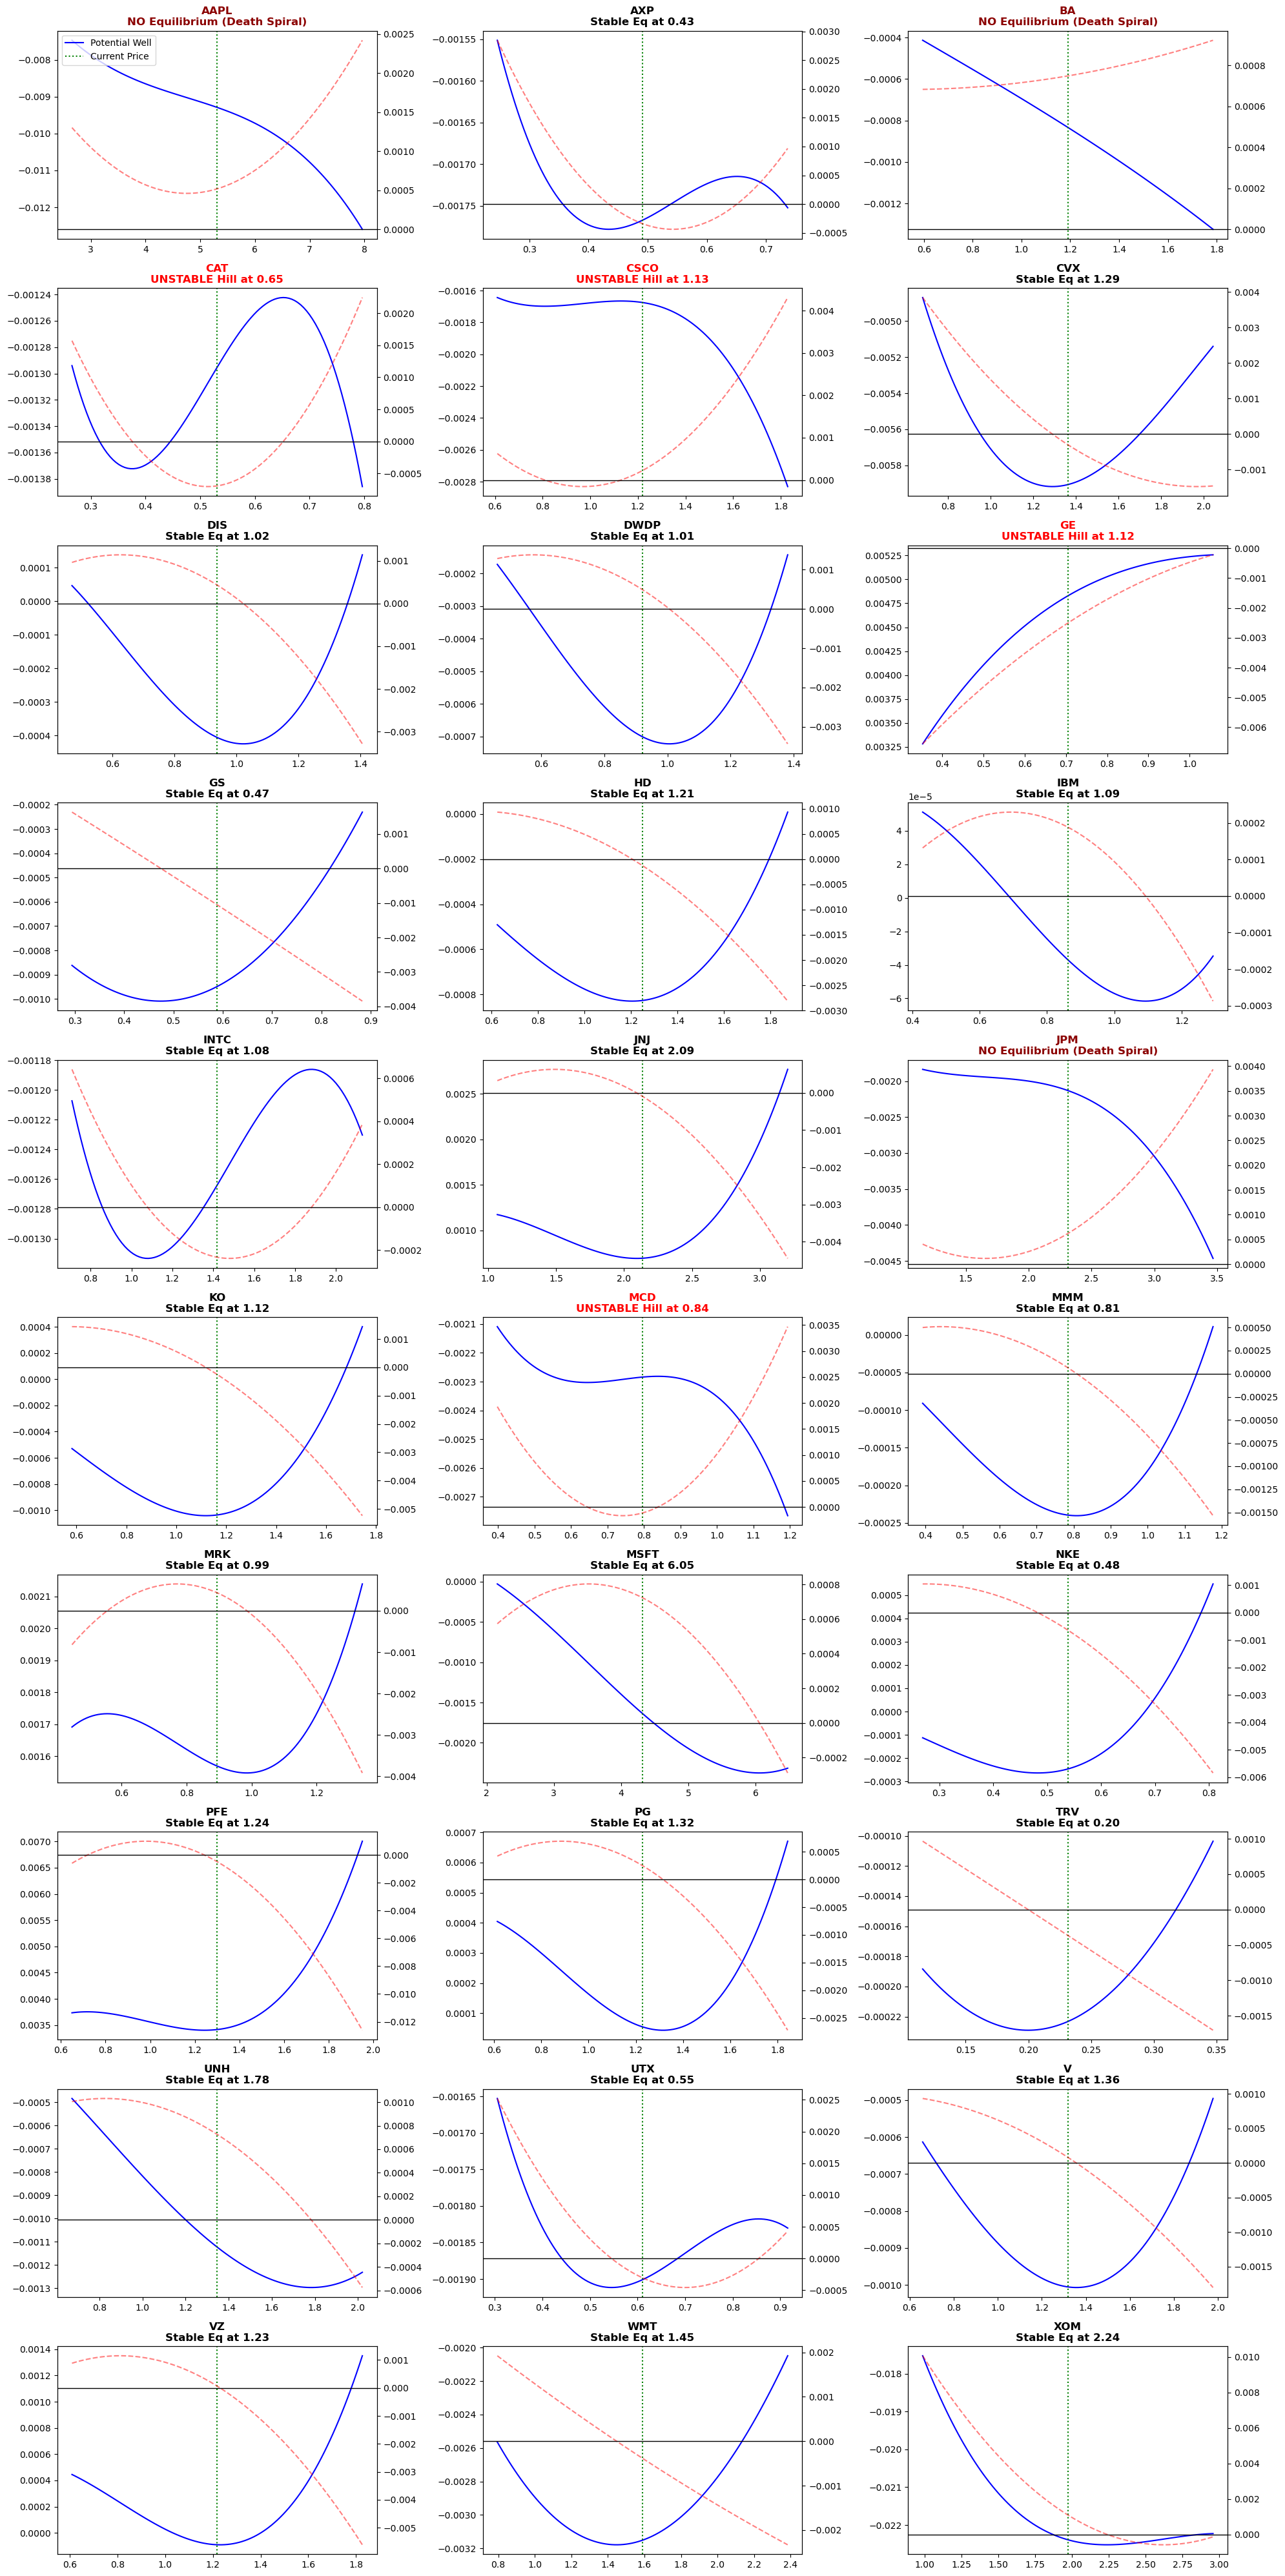

In [18]:
# --- CELL 18: Potential Well Plots ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# Get current parameters
t_val = theta.numpy()
k_val = kappa.numpy()
s_val = sigma.numpy()
g_val = g.numpy()
w_val = w_logits.numpy()

# Average signal contribution for the 'static' well
avg_z1 = tf.reduce_mean(tf.math.log(1.0 + z1_t), axis=0).numpy()
avg_z2 = tf.reduce_mean(tf.math.log(1.0 + z2_t), axis=0).numpy()

for i in range(num_stocks):
    # Current Market Cap
    current_x = x_t[-1, i].numpy()
    
    # Calculate the components
    signal_contrib = (w_val[i, 0] * avg_z1[i]) + (w_val[i, 1] * avg_z2[i])
    base_drift = t_val[i] - 0.5 * (s_val[i]**2) + signal_contrib
    
    # --- REALITY CHECK: Solve for Equilibrium Roots ---
    # Drift Equation: mu(x) = base - k*x - g*x^2 = 0
    # Coefficients for np.roots (ax^2 + bx + c): [-g, -k, base]
    roots = np.roots([-g_val[i], -k_val[i], base_drift])
    
    # Filter for real, positive roots (Market Cap must be > 0)
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[real_roots > 0]
    
    # Determine Status
    if len(valid_roots) > 0:
        # Find root closest to current price
        closest_root = valid_roots[np.argmin(np.abs(valid_roots - current_x))]
        
        # Check Stability: Derivative d(mu)/dx = -k - 2gx
        # If derivative < 0, force restores equilibrium (Stable)
        # If derivative > 0, force pushes away (Unstable)
        slope = -k_val[i] - (2 * g_val[i] * closest_root)
        
        if slope < 0:
            status = f"Stable Eq at {closest_root:.2f}"
            title_color = 'black'
        else:
            status = f"UNSTABLE Hill at {closest_root:.2f}"
            title_color = 'red'
    else:
        status = "NO Equilibrium (Death Spiral)"
        title_color = 'darkred'

    # --- Plotting ---
    # Define range relative to current price to see the local dynamic
    x_range = np.linspace(current_x * 0.5, current_x * 1.5, 100)
    
    # 1. The Force (Drift)
    force = base_drift - (k_val[i] * x_range) - (g_val[i] * (x_range**2))
    
    # 2. The Potential Well: U(x) = -Integral(force)
    potential = -(base_drift * x_range) + (0.5 * k_val[i] * x_range**2) + ((1/3) * g_val[i] * x_range**3)
    
    ax2 = axes[i].twinx() 
    axes[i].plot(x_range, potential, color='blue', label='Potential Well')
    ax2.plot(x_range, force, color='red', linestyle='--', alpha=0.5, label='Drift')
    ax2.axhline(0, color='black', lw=1)
    
    # Mark current Market Cap
    axes[i].axvline(current_x, color='green', linestyle=':', label='Current Price')
    
    # Set Dynamic Title
    axes[i].set_title(f"{df_cap.columns[i]}\n{status}", color=title_color, fontweight='bold')
    
    if i == 0:
        axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

The median default probability of 1.05% falls within the investment-grade to high-yield transition zone, with most stocks near zero and a few outliers driving the 3.84% mean. The escape rates are very small, 10⁻⁴ to 10⁻⁵ per day, consistent with how large-cap stocks actually behave: prices exhibit persistent trends punctuated by abrupt regime shifts from re-ratings, crashes, policy shocks, or structural changes.

While Kramers' escape rate is evaluated here as a post-calibration diagnostic, it naturally suggests a regularization strategy in which parameter sets producing shallow or noise-dominated barriers (ΔV ≲ σ²) are penalized during estimation, ensuring physically meaningful potential structures.

## Part 3: Propose and analyse your own signals  (Max 10 points)

In this part, you will experiment with other signals. Propose a signal and explain why it is interesting to 
include this signal in the portfolio analysis. Then add your favorite signal or signals to the previous benchmarck signals (or alternatively you can replace them), and repeat the analysis of model calibration. State your conclusions.


In the last course, I introduced a forward-looking momentum signal, Volatility-Adjusted Momenutum (VAM), as a counterbalance to the backward-looking MA signals. The idea was to allow the IRL model to drift beyond simple mean reversion if a strong movement or regime chage was detected. Additionally, I added VAM with a sliding lookback window to smooth out abrupt, choppy, noisy trends. The result was a slight improvement in both fit and out of sample performance. 

However, the QED framework introduces a fundamentally different dynamic structure through the quartic potential term, g. A momentum signal is now structurally endogenous to the model. I believe this will make the simple addition of VAM less impactful. Also, 10 and 30-day MAs are correlated. Instead, I will introduce a signal stack that I believe is more orthagonal and reflects a more practical application of this model with the given dataset,

Part 3 will test the following:  
MA(20) - an industry standard trend signal where trade activity tends to occur.  
RSI(14) - an standard oscillating mean reversion signal  
VAM - a volatility-based regime shift signal which will use a sliding lookback window of 10-60 days


In [19]:
# CELL 19: Data Prep

# --- Signal 3: MA(20) Trend ---
ma20 = df_cap.rolling(window=20).mean()
ma20_avg = ma20 / avg_market_cap
ma20_rebased = ma20_avg / ma20_avg.apply(lambda x: x.loc[x.first_valid_index()])

# --- Signal 4: RSI(14) Mean Reversion ---
delta = df_cap_avg.diff()
gain = (delta.where(delta > 0, 0)).fillna(0)
loss = (-delta.where(delta < 0, 0)).fillna(0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
rsi = 100 - (100 / (1 + rs))
rsi_signal = (rsi - 50) / 100

# --- Signal 5: VAM Momentum ---
# Log Returns
vam_S = np.log(df_cap_avg)
vam_r = vam_S.diff(1)

# Dynamic Window
vol_short = vam_r.rolling(window=10).std()
vol_long = vam_r.rolling(window=60).std()
vol_ratio = (vol_short / vol_long).clip(0, 0.9).fillna(1.0)
lb_window = (10 + (60 - 10) * (1.0 - vol_ratio)).astype(int)

# Momentum Signal
vam_signal = pd.DataFrame(index=df_cap_avg.index, columns=df_cap_avg.columns)
for col in df_cap_avg.columns:
    prices = df_cap_avg[col].values
    lbs = lb_window[col].values
    mom_array = np.zeros(len(prices))
    # Loodback loop for each timestamp 'i'
    for i in range(60, len(prices)):
        lb = lbs[i]
        past_price = prices[i - lb]
        # Average drift
        mom_array[i] = np.log(prices[i] / past_price) / lb

    vam_signal[col] = mom_array

# Signals
signal_3 = ma20_rebased.pct_change(periods=1)
signal_4 = rsi_signal.fillna(0)
signal_5 = vam_signal

# Alignment
z3_data = signal_3.loc[common_idx]
z4_data = signal_4.loc[common_idx]
z5_data = signal_5.loc[common_idx]

# Tensors
z3_t = tf.constant(z3_data.values, dtype=tf.float32)
z4_t = tf.constant(z4_data.values, dtype=tf.float32)
z5_t = tf.constant(z5_data.values, dtype=tf.float32)

print(f"Part 3 Signals Prepared:")
print(f"Signal 3 (MA20): {z3_t.shape}")
print(f"Signal 4 (RSI14): {z4_t.shape}")
print(f"Signal 5 (VAM): {z5_t.shape}")

Part 3 Signals Prepared:
Signal 3 (MA20): (2049, 30)
Signal 4 (RSI14): (2049, 30)
Signal 5 (VAM): (2049, 30)


In [20]:
# --- CELL 20: Model Definition ---

# Variable Initializations (Warm started)
theta_2 = tf.Variable(theta.numpy(), name="theta_2")
sigma_2 = tf.Variable(sigma.numpy(), name="sigma_2")
kappa_2 = tf.Variable(kappa.numpy(), name="kappa_2")
g_2 = tf.Variable(g.numpy(), name="g_2")

# Weights Initialized to zero
w_2_init = np.zeros((num_stocks, 3)) 
w_logits_2 = tf.Variable(w_2_init, dtype=tf.float32, name="w_logits_2")

def get_loss_2():
    # Log Returns
    log_x = tf.math.log(x_t)
    log_x_next = tf.math.log(tf.roll(x_t, shift=-1, axis=0))
    dy = log_x_next - log_x
    
    # Signals
    z3_log = tf.math.log(1.0 + z3_t) # MA20 in log form
    z4_lin = z4_t # RSI in linear form
    z5_log = z5_t # VAM as drift term

    # Weighted Signal Returns
    W3 = w_logits_2[:, 0]
    W4 = w_logits_2[:, 1]
    W5 = w_logits_2[:, 2]
    wtd_rets = W3 * z3_log + W4 * z4_lin + W5 * z5_log

    # QED Model Drift: (theta - 0.5*sigma^2) - kappa*X - g*X^2
    exp_dy = (theta_2 - 0.5 * tf.square(sigma_2) + wtd_rets) - kappa_2 * tf.exp(log_x) - g_2 * tf.exp(2.0 * log_x)
    
    # Residuals
    v_res = (dy - exp_dy)[:-1, :]
    
    # Gaussian Negative Log-Likelihood
    sq_dist = tf.reduce_sum(tf.square(v_res / sigma_2))
    T_eff = tf.cast(tf.shape(v_res)[0], tf.float32)
    log_det = T_eff * tf.reduce_sum(tf.math.log(tf.square(sigma_2)))
    
    NLL = 0.5 * (sq_dist + log_det)

    return NLL

print("Part 3 Model Defined (Warm Start Physics, Fresh Weights)")

Part 3 Model Defined (Warm Start Physics, Fresh Weights)


In [21]:
# --- CELL 21: Optimization ---
optimizer_2 = tf.optimizers.Adam(learning_rate=0.0001)
variables_2 = [theta_2, kappa_2, sigma_2, g_2, w_logits_2]

print("Calibrating 3 Signal Model (MA20, RSI, VAM)...")
for i in range(2501):
    with tf.GradientTape() as tape:
        loss_val_2 = get_loss_2()

    # Gradients
    grads = tape.gradient(loss_val_2, variables_2)
    optimizer_2.apply_gradients(zip(grads, variables_2))

    # Stability constraints
    kappa_2.assign(tf.clip_by_value(kappa_2, -1.0, 1.0))
    sigma_2.assign(tf.maximum(0.00001, sigma_2))
    theta_2.assign(tf.clip_by_value(theta_2, -0.5, 0.5))
    g_2.assign(tf.clip_by_value(g_2, -0.1, 0.1))

    if i % 500 == 0:
        print(f"Iteration {i:4} | Loss: {loss_val_2.numpy():.4f}")

print("Done")

# --- Signal Contribution Analysis ---
W3 = w_logits_2[:, 0] # MA20 Weight
W4 = w_logits_2[:, 1] # RSI Weight
W5 = w_logits_2[:, 2] # VAM Weight

z3 = tf.math.log(1.0 + z3_t)
z4 = z4_t                    
z5 = z5_t                    

ma20_cont = W3 * z3
rsi_cont  = W4 * z4
vam_cont  = W5 * z5

print(f"\nSignal Contribution Analysis (Part 3):")
print(f"MA20 (Signal 3) contribution std: {tf.math.reduce_std(ma20_cont).numpy():.6f}")
print(f"RSI  (Signal 4) contribution std: {tf.math.reduce_std(rsi_cont).numpy():.6f}")
print(f"VAM  (Signal 5) contribution std: {tf.math.reduce_std(vam_cont).numpy():.6f}")

loss_2 = loss_val_2.numpy()

Calibrating 3 Signal Model (MA20, RSI, VAM)...
Iteration    0 | Loss: -234774.9219
Iteration  500 | Loss: -234813.6875
Iteration 1000 | Loss: -234824.5625
Iteration 1500 | Loss: -234831.8750
Iteration 2000 | Loss: -234836.7188
Iteration 2500 | Loss: -234840.0000
Done

Signal Contribution Analysis (Part 3):
MA20 (Signal 3) contribution std: 0.000330
RSI  (Signal 4) contribution std: 0.000393
VAM  (Signal 5) contribution std: 0.000449


In [22]:
# --- CELL 22: VAM Final Calibration Results ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Extract direct weights
final_weights_2 = w_logits_2.numpy()
W3_final = final_weights_2[:, 0]
W4_final = final_weights_2[:, 1]
W5_final = final_weights_2[:, 2]

results_2 = {
    'Ticker': df_cap.columns,
    'Theta': theta_2.numpy(),
    'Kappa': kappa_2.numpy(),
    'Sigma': sigma_2.numpy(),
    'g': g_2.numpy(),
    'MA(20)': W3_final,
    'RSI(14)': W4_final,
    'VAM': W5_final
}
df_results_2 = pd.DataFrame(results_2)

print("---------------------- Part 3: Final VAM Calibration Results ---------------------")
display(df_results_2)

# Check for g values significantly different from zero
significant_g_2 = df_results_2[df_results_2['g'].abs() > 1e-3].shape[0]
print(f"\nStocks with detectable non-linear dynamics: {significant_g_2} / {num_stocks}")

---------------------- Part 3: Final VAM Calibration Results ---------------------


,Ticker,Theta,Kappa,Sigma,g,MA(20),RSI(14),VAM
0,AAPL,0.004794,0.001801,0.015795,-0.000161,-0.028302,0.000801,0.002081
1,AXP,0.010983,0.041604,0.014696,-0.038385,-0.176940,-0.000345,0.046708
2,BA,0.000617,0.000082,0.014931,-0.000705,-0.054515,0.003065,-0.204462
3,CAT,0.008185,0.033169,0.016649,-0.031036,0.012908,0.004427,-0.188016
4,CSCO,0.006188,0.012759,0.016074,-0.006516,0.171662,-0.001483,-0.185683
5,CVX,0.005471,0.003384,0.013388,0.000590,-0.142707,0.003917,-0.124018
6,DIS,-0.000703,-0.006791,0.013515,0.005791,-0.062658,-0.003378,0.155672
7,DWDP,-0.000707,-0.008024,0.023262,0.006763,-0.038064,0.001942,-0.053845
8,GE,-0.012155,-0.018984,0.014021,0.007139,-0.148955,0.000880,0.157684
9,GS,0.004099,0.008127,0.016814,0.000265,0.061139,-0.002668,0.111412



Stocks with detectable non-linear dynamics: 25 / 30


In [23]:
# --- CELL 23: Weight & Relative Importance Analysis ---

# Extract the final calibrated weights
w_final_2 = w_logits_2.numpy()

# Create the Analysis DataFrame
weight_df = pd.DataFrame(w_final_2, index=range(num_stocks), columns=['M(20)', 'RSI(14)', 'VAM'])

# Calculate Weight Stats
mean_weights = weight_df.mean()

# Calculate Relative Importance (%)
contribution_stds = pd.Series({
    'M(20)': tf.math.reduce_std(W3 * z3).numpy(),
    'RSI(14)': tf.math.reduce_std(W4 * z4).numpy(),
    'VAM': tf.math.reduce_std(W5 * z5).numpy()
})
importance_pct = (contribution_stds / contribution_stds.sum()) * 100

print("--- CALIBRATED WEIGHT SUMMARY ---")
print(weight_df.describe().loc[['mean', 'std', 'min', 'max']])

print("\n--- RELATIVE SIGNAL IMPORTANCE ---")
for signal, imp in importance_pct.items():
    print(f"{signal:5} : {imp:6.2f}%")

# 5. Model Improvement Summary
ll_improvement = abs(loss_2 - loss_with_signals)
print("\n--- CALIBRATION PERFORMANCE ---")
print(f"Log-Likelihood Improvement: {ll_improvement:.4f}")

--- CALIBRATED WEIGHT SUMMARY ---
         M(20)   RSI(14)       VAM
mean -0.071879  0.000817 -0.094568
std   0.107792  0.002145  0.125935
min  -0.211985 -0.003378 -0.212013
max   0.181209  0.004427  0.178222

--- RELATIVE SIGNAL IMPORTANCE ---
M(20) :  28.14%
RSI(14) :  33.53%
VAM   :  38.33%

--- CALIBRATION PERFORMANCE ---
Log-Likelihood Improvement: 3.0938


In [24]:
# --- CELL 24: Final Calibration (VAM - Kramer's Rate) ---

# Extract parameters from the calibrated VAM tensors
t_2 = theta_2.numpy()
k_2 = kappa_2.numpy()
s_2 = sigma_2.numpy()
g_2 = g_2.numpy()

y_min_2 = []
y_bar_2 = []
r_2 = []
bar_pass_2 = []

for i in range(num_stocks):
    t, k, s, g_val = t_2[i], k_2[i], s_2[i], g_2[i]
    # Base alpha
    alpha = t - 0.5 * s**2
    
    # Critical Points: V'(y) = 0 => g*u^2 + k*u - alpha = 0 (u = exp(y))
    u_roots = np.roots([g_val, k, -alpha])
    u_real = u_roots[np.isreal(u_roots)].real
    u_pos = sorted(u_real[u_real > 0])
    
    y_min_val, y_bar_val, r_val, pass_test = np.nan, np.nan, np.nan, False
    
    if len(u_pos) == 2:
        u_1, u_2 = u_pos[0], u_pos[1]
        
        # Second Derivatives: V''(y) = k*u + 2*g*u^2
        v_pp_1 = k * u_1 + 2 * g_val * u_1**2
        v_pp_2 = k * u_2 + 2 * g_val * u_2**2
        
        # One minimum (V'' > 0), one maximum (V'' < 0)
        if (v_pp_1 * v_pp_2) < 0:
            u_min = u_1 if v_pp_1 > 0 else u_2
            u_max = u_2 if v_pp_1 > 0 else u_1
            
            y_min_val = np.log(u_min)
            y_bar_val = np.log(u_max)
            
            # Potential Difference
            V = lambda y_val: -alpha * y_val + k * np.exp(y_val) + 0.5 * g_val * np.exp(2 * y_val)
            delta_V = V(y_bar_val) - V(y_min_val)

            # Kramers Rate
            if delta_V > 0:
                curv_min = k * u_min + 2 * g_val * u_min**2
                curv_max = k * u_max + 2 * g_val * u_max**2
                prefactor = np.sqrt(curv_min * abs(curv_max)) / (2 * np.pi)
                r_val = prefactor * np.exp(-delta_V / (s**2))
                pass_test = delta_V > 3 * (s**2) / 2

    y_min_2.append(y_min_val)
    y_bar_2.append(y_bar_val)
    r_2.append(r_val)
    bar_pass_2.append(pass_test)

print("Kramer's Rate Analysis (VAM) Complete.")

Kramer's Rate Analysis (VAM) Complete.


In [25]:
# --- CELL 25: Kramer's r Results (VAM Model) ---
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', None)

# Use the renamed variables from Cell 24
df_results_2 = pd.DataFrame({
    'Ticker': df_cap.columns,
    'Theta': t_2,
    'Kappa': k_2,
    'Sigma': s_2,
    'g': g_2,
    'Escape_r': r_2,
    'Bar Pass': bar_pass_2,
    'y_min': y_min_2,
    'y_max': y_bar_2
})

significant_g_vam = df_results_2[df_results_2['g'].abs() > 1e-3].shape[0]

print("--------------------- Part 3: Final VAM Calibration & Kramer's r Results ---------------------")
display(df_results_2)
print(f"\nStocks with detectable non-linear dynamics (VAM): {significant_g_vam} / {num_stocks}")

--------------------- Part 3: Final VAM Calibration & Kramer's r Results ---------------------


,Ticker,Theta,Kappa,Sigma,g,Escape_r,Bar Pass,y_min,y_max
0,AAPL,0.004794,0.001801,0.015795,-0.000161,2.449346e-04,False,1.408909,1.956694
1,AXP,0.010983,0.041604,0.014696,-0.038385,4.160200e-04,False,-0.820681,-0.440481
2,BA,0.000617,0.000082,0.014931,-0.000705,NaN,False,NaN,NaN
3,CAT,0.008185,0.033169,0.016649,-0.031036,2.422387e-04,False,-0.988292,-0.361636
4,CSCO,0.006188,0.012759,0.016074,-0.006516,2.863078e-04,False,-0.211026,0.138273
5,CVX,0.005471,0.003384,0.013388,0.000590,NaN,False,NaN,NaN
6,DIS,-0.000703,-0.006791,0.013515,0.005791,1.132224e-07,True,0.040214,-2.027030
7,DWDP,-0.000707,-0.008024,0.023262,0.006763,1.702690e-05,True,0.047501,-1.981185
8,GE,-0.012155,-0.018984,0.014021,0.007139,4.402889e-04,False,0.442593,0.097727
9,GS,0.004099,0.008127,0.016814,0.000265,NaN,False,NaN,NaN



Stocks with detectable non-linear dynamics (VAM): 25 / 30


In [26]:
# --- CELL 26: Interpretation and Analysis (VAM Model) ---

# Use the VAM dataframe
valid_rates = df_results_2[df_results_2['Escape_r'].notna()]
passed_barrier = df_results_2[df_results_2['Bar Pass'] == True]

print(f"\nStocks with valid barrier structure (VAM): {len(valid_rates)} / {num_stocks}")
print(f"Stocks passing barrier significance test (ΔV > 3σ²/2): {len(passed_barrier)} / {num_stocks}")

if len(valid_rates) > 0:
    print(f"\nEscape Rate Statistics (VAM):")
    print(f"  Mean:   {valid_rates['Escape_r'].mean():.6e} per day")
    print(f"  Median: {valid_rates['Escape_r'].median():.6e} per day")
    print(f"  Min:    {valid_rates['Escape_r'].min():.6e} per day")
    print(f"  Max:    {valid_rates['Escape_r'].max():.6e} per day")
    
    # Convert to annual default probability: P(default) = 1 - exp(-r * 252)
    annual_default = 1 - np.exp(-valid_rates['Escape_r'] * 252)
    
    print(f"\nImplied Annual Default Probabilities (VAM):")
    print(f"  Mean:   {annual_default.mean():.2%}")
    print(f"  Median: {annual_default.median():.2%}")
    print(f"  Range:  [{annual_default.min():.2%}, {annual_default.max():.2%}]")


Stocks with valid barrier structure (VAM): 21 / 30
Stocks passing barrier significance test (ΔV > 3σ²/2): 11 / 30

Escape Rate Statistics (VAM):
  Mean:   1.445191e-04 per day
  Median: 8.354041e-05 per day
  Min:    1.132224e-07 per day
  Max:    4.402889e-04 per day

Implied Annual Default Probabilities (VAM):
  Mean:   3.51%
  Median: 2.08%
  Range:  [0.00%, 10.50%]


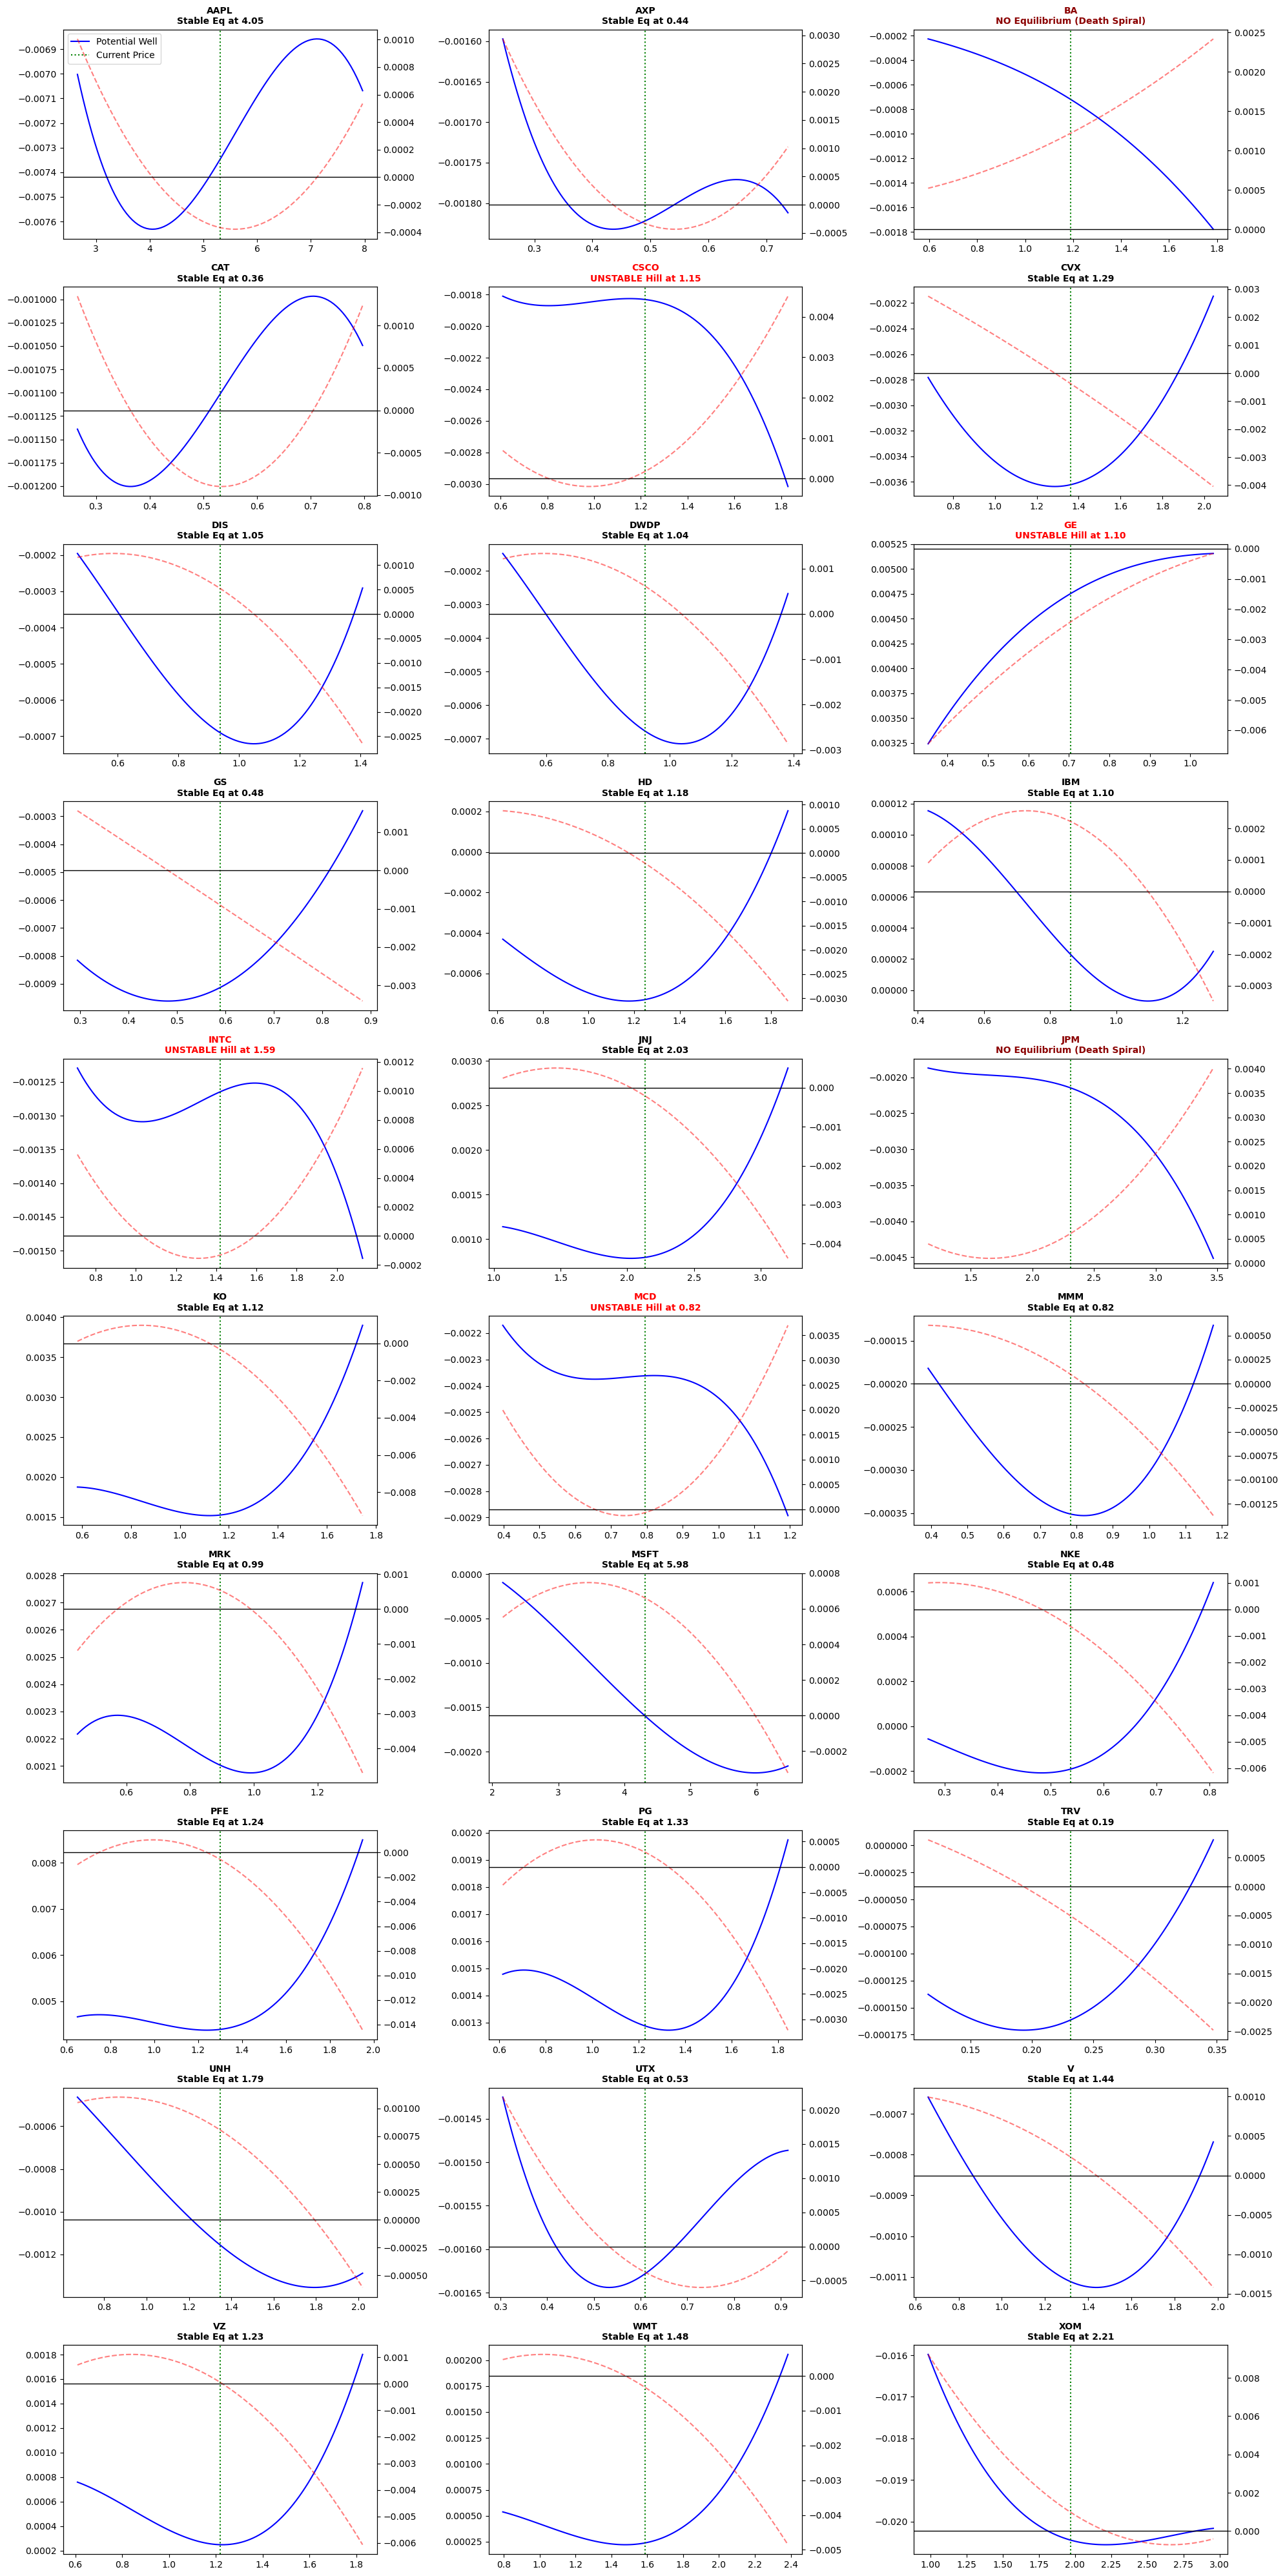

In [27]:
# --- CELL 27: Potential Well Plots (VAM Model) ---
n_cols = 3
n_rows = (num_stocks + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, n_rows * 4))
axes = axes.flatten()

# 1. Get VAM parameters
t_val = theta_2
k_val = kappa_2
s_val = sigma_2
g_val = g_2
w_val = w_logits_2.numpy() # Raw weights

# 2. Calculate Average Signal Contributions (Including VAM)
# We assume the "Static" well exists when signals are at their average levels
avg_z1 = tf.reduce_mean(tf.math.log(1.0 + z1_t), axis=0).numpy() # MA10
avg_z2 = tf.reduce_mean(tf.math.log(1.0 + z2_t), axis=0).numpy() # MA30
avg_z3 = tf.reduce_mean(z3_t, axis=0).numpy()                    # VAM (Already log-drift)

for i in range(num_stocks):
    # Current Market Cap
    current_x = x_t[-1, i].numpy()
    
    # 3. Calculate Total Signal Contribution (3 Signals)
    # The drift is modified by the weighted sum of all 3 average signals
    signal_contrib = (w_val[i, 0] * avg_z1[i]) + \
                     (w_val[i, 1] * avg_z2[i]) + \
                     (w_val[i, 2] * avg_z3[i])
                     
    base_drift = t_val[i] - 0.5 * (s_val[i]**2) + signal_contrib
    
    # --- REALITY CHECK: Solve for Equilibrium Roots ---
    # Drift Equation: mu(x) = base - k*x - g*x^2 = 0
    roots = np.roots([-g_val[i], -k_val[i], base_drift])
    
    # Filter for real, positive roots
    real_roots = roots[np.isreal(roots)].real
    valid_roots = real_roots[real_roots > 0]
    
    # Determine Status
    if len(valid_roots) > 0:
        # Find root closest to current price
        closest_root = valid_roots[np.argmin(np.abs(valid_roots - current_x))]
        
        # Stability Check: Derivative < 0 means restoring force
        slope = -k_val[i] - (2 * g_val[i] * closest_root)
        
        if slope < 0:
            status = f"Stable Eq at {closest_root:.2f}"
            title_color = 'black'
        else:
            status = f"UNSTABLE Hill at {closest_root:.2f}"
            title_color = 'red'
    else:
        status = "NO Equilibrium (Death Spiral)"
        title_color = 'darkred'

    # --- Plotting ---
    x_range = np.linspace(current_x * 0.5, current_x * 1.5, 100)
    
    # The Force (Drift)
    force = base_drift - (k_val[i] * x_range) - (g_val[i] * (x_range**2))
    
    # The Potential Well: U(x) = -Integral(force)
    potential = -(base_drift * x_range) + (0.5 * k_val[i] * x_range**2) + ((1/3) * g_val[i] * x_range**3)
    
    ax2 = axes[i].twinx() 
    axes[i].plot(x_range, potential, color='blue', label='Potential Well')
    ax2.plot(x_range, force, color='red', linestyle='--', alpha=0.5, label='Drift')
    ax2.axhline(0, color='black', lw=1)
    
    # Mark current Market Cap
    axes[i].axvline(current_x, color='green', linestyle=':', label='Current Price')
    
    axes[i].set_title(f"{x_data.columns[i]}\n{status}", color=title_color, fontweight='bold', fontsize=10)
    
    if i == 0:
        axes[i].legend(loc='upper left')

plt.tight_layout()
plt.show()

## Part 4 (Optional): Show me something else (Max 10 points).

Here you can develop any additional analysis of the model that you may find interesting (One possible suggestion is 
presented above, but you should feel free to choose your own topic). Present your case and finding/conclusions.


In [28]:
# Put the rest of your code and analysis for Part 3 here.